##### Motivation behind prom_connector - would like to have a functionality to analyze the logs of open5gs applications such as UPF,AMF, etc.

### tsdb to json

0. Install go -   sudo yum install golang -y

1. Copy a tsdb chunk from s3 using 
aws s3 cp s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/<\tsdb-block> <\local-path> --recursive
2. clone git@github.com:DISHDevEx/prometheus-tsdb-dump.git
3. cd prometheus-tsdb-dump
4. run main.go -block '<\path-to-tsdb-block>' -format victoriametrics > '<\filename>'.json


In [4]:
!aws --version

aws-cli/1.27.111 Python/3.7.10 Linux/4.14.314-237.533.amzn2.x86_64 botocore/1.29.111


### json to df 

In [7]:
! pip install devex_sdk

  Using cached devex_sdk-1.0.2-py3-none-any.whl (40 kB)
  Using cached configparser-5.3.0-py3-none-any.whl (19 kB)
  Using cached fastparquet-0.8.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
  Using cached pyspark-3.4.0-py2.py3-none-any.whl
  Using cached cramjam-2.6.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.0 MB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [5]:
from devex_sdk import setup_runner
setup_runner()

b"Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]\nHit:2 http://deb.debian.org/debian buster InRelease\nHit:3 http://deb.debian.org/debian buster-updates InRelease\nGet:4 http://security.debian.org/debian-security buster/updates/main amd64 Packages [518 kB]\nFetched 553 kB in 1s (1016 kB/s)\nReading package lists...\nBuilding dependency tree...\nReading state information...\n73 packages can be upgraded. Run 'apt list --upgradable' to see them.\nReading package lists...\nBuilding dependency tree...\nReading state information...\nsudo is already the newest version (1.8.27-1+deb10u5).\n0 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\ndefault-jre is already the newest version (2:1.11-71).\n0 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.\nReading package lists...\nBuilding dependency tree...\nReading state information...\npython3 is already

In [1]:
from devex_sdk import Spark_Data_Connector, Nested_Json_Connector
from pyspark.sql.functions import col, count
import pyspark.sql.functions as F
from pyspark.sql.functions import explode, from_unixtime, col
import time 
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import FloatType, TimestampType


In [77]:
!aws s3 cp s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/ df15 --recursive

download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/meta.json to df15/meta.json
download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/chunks/000001 to df15/chunks/000001
download: s3://open5gs-respons-logs/prometheus-metrics/respons-amf-forecaster/01H1SRVSY16XHX27E678RP2PZB/index to df15/index


In [4]:
def get_amf_data(json_object_path, column_name = None, pod_id = None):
    obj = Nested_Json_Connector(json_object_path)
    err, data = obj.read_nested_json()
    amf_data = data.filter(col("metric_pod").startswith('open5gs-amf') & (col("metric_namespace")=="openverso"))
    if column_name:
        amf_data.filter(col("metric___name__") == column_name)
    if pod_id:
        amf_data.filter(col("metric_pod") ==  pod_id)
    return amf_data

def transform_dataframe(amf_data):
    # Explode the array of Unix timestamps and values into individual rows
    exploded_df_timestamps = amf_data.select(F.posexplode(amf_data.timestamps).alias("pos", "unix_timestamps"), 'metric_pod', 'metric___name__')
    exploded_df_values = amf_data.select(F.posexplode(amf_data.values).alias("pos", "values"), 'metric_pod', 'metric___name__')
    exploded_df = exploded_df_timestamps.join(exploded_df_values, ["pos", "metric_pod", "metric___name__"])
    
    # Order the DataFrame by the Timestamp column in ascending order
    sorted_df = exploded_df.orderBy("unix_timestamps")
    sorted_df = sorted_df.withColumn("unix_timestamps", F.col("unix_timestamps") / 1000)
    converted_df = sorted_df.withColumn("date_time", F.from_unixtime("unix_timestamps", format='yyyy-MM-dd HH:mm:ss')).drop("unix_timestamps")                                       
    
    #Type Casting
    extracted_df = converted_df.withColumn("date_time", col("date_time").cast(TimestampType()))
    extracted_df = extracted_df.withColumn("values", col("values").cast(FloatType()))
    return extracted_df

def get_values(amf_data, column_name = None, pod_id = None):
    if column_name:
        amf_data = amf_data.filter(col("metric___name__") == column_name)
    if pod_id:
        amf_data = amf_data.filter(col("metric_pod") ==  pod_id)
    return amf_data

def comparisson_plot(amf_data, metric1, metric2, pod1, pod2):
    time1 = time.time()
    data1 = get_values(amf_data, metric1, pod1)
    data2 = get_values(amf_data, metric2, pod2)
    df_avg1 = data1.groupBy('date_time', 'metric___name__').agg(F.avg('values').alias('avg_values'))
    df_avg2 = data2.groupBy('date_time', 'metric___name__').agg(F.avg('values').alias('avg_values'))
    # Convert to Pandas DataFrame
    df_pandas1 = df_avg1.toPandas()
    df_pandas2 = df_avg2.toPandas()
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Loop through each metric name and plot its data
    for metric_name, group in df_pandas1.groupby('metric___name__'):
        group.plot(x='date_time', y='avg_values', ax=ax, label=metric_name)
    for metric_name, group in df_pandas2.groupby('metric___name__'):
        group.plot(x='date_time', y='avg_values', ax=ax, label=metric_name)
    plt.show()
    time2 = time.time()
    print(time2 - time1)

In [20]:
time1 = time.time()
json_object_path = 'df72.json'
data = get_amf_data(json_object_path)
amf_data = transform_dataframe(data)
time2 = time.time()
print(time2 - time1)

Nested_Json_Connector initialized with the following s3_file_path:df72.json
30.392711400985718


In [22]:
data.select('metric_pod').rdd.flatMap(lambda x: x).distinct().collect()

['open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v']

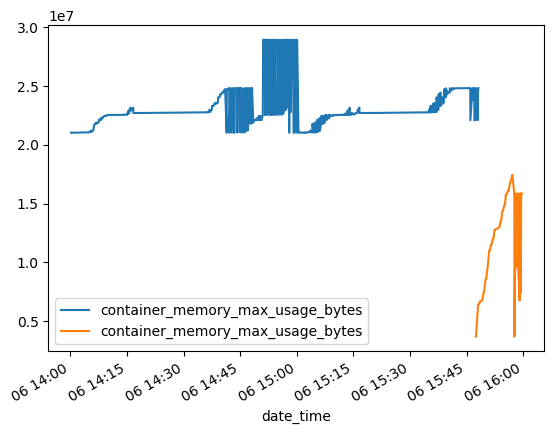

26.25984001159668


In [23]:
comparisson_plot(amf_data, 'container_memory_max_usage_bytes', 'container_memory_max_usage_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-54cc5d554b-pjq4v')

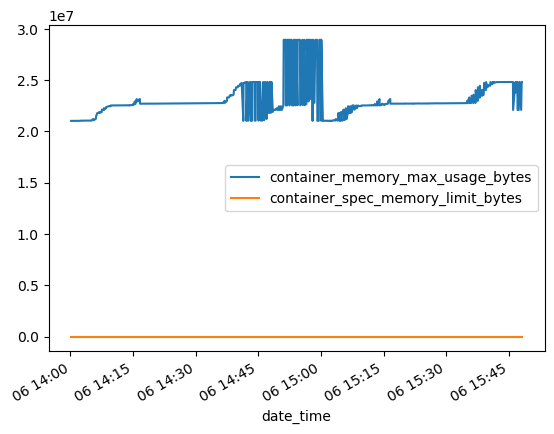

19.95301342010498


In [27]:
comparisson_plot(amf_data, 'container_memory_max_usage_bytes', 'container_spec_memory_limit_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

Q. When is the time interval between a pod transition ?


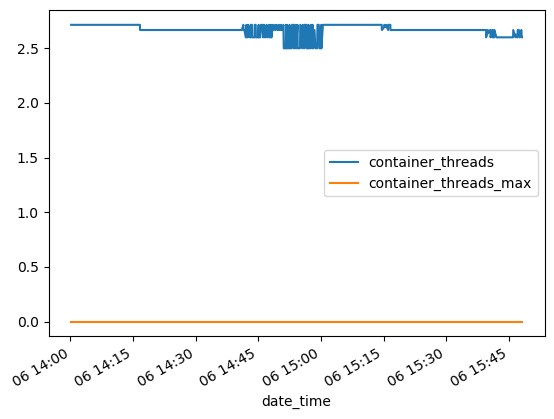

20.11312961578369


In [24]:
comparisson_plot(amf_data, 'container_threads', 'container_threads_max', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

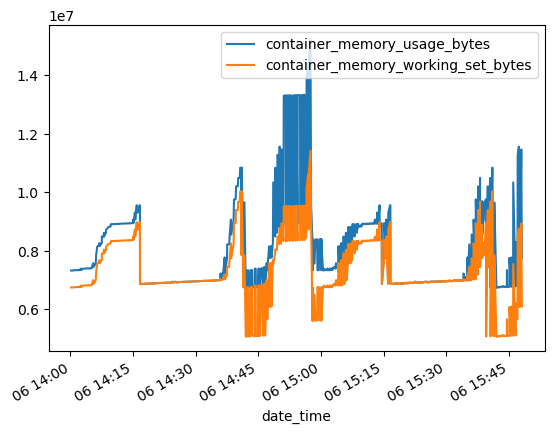

20.200387477874756


In [25]:
comparisson_plot(amf_data, 'container_memory_usage_bytes', 'container_memory_working_set_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

Why is there a fluctuation between 14:45 and 15 ?

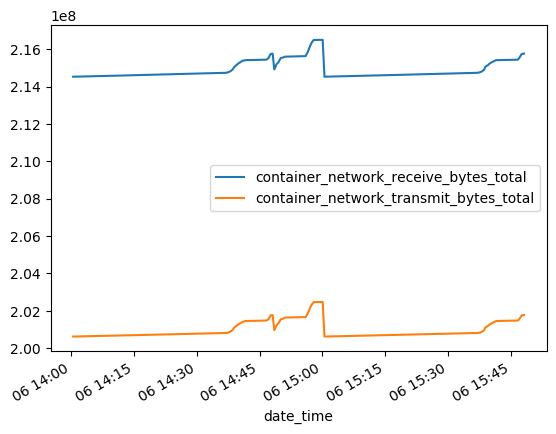

19.798514127731323


In [26]:
comparisson_plot(amf_data, 'container_network_receive_bytes_total', 'container_network_transmit_bytes_total', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

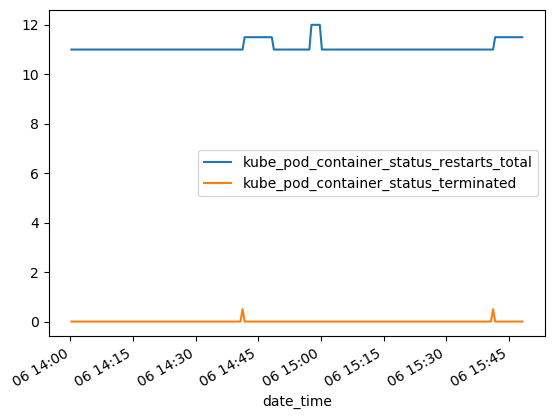

20.311317443847656


In [28]:
comparisson_plot(amf_data, 'kube_pod_container_status_restarts_total', 'kube_pod_container_status_terminated', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

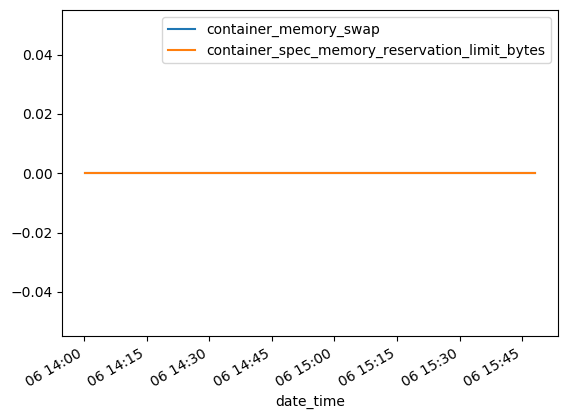

22.397860527038574


In [29]:
comparisson_plot(amf_data, 'container_memory_swap', 'container_spec_memory_reservation_limit_bytes', 'open5gs-amf-6d85b8c465-fzg2t', 'open5gs-amf-6d85b8c465-fzg2t')

In [ ]:
drop_null_columns(df.filter(col("metric___name__") == 'kube_pod_labels')).select('values').rdd.flatMap(lambda x: x).collect()[0]

In [11]:
def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > 0]
    df = df.drop(*to_drop)
    return df

In [51]:
!go run main.go -block df15 -format victoriametrics > df15.json

/bin/bash: go: command not found


### Once we have the raw dataframe, further transformations can be performed as per the use case. Few examples : 
#### Identify Metrics of Interest 
- container = kube state metrics 
  - metric__name__ = Those starting with kube_
- container = open5gs-*
  - metric__name__ = container_memory_usage_bytes , container_cpu_usage_seconds_total, etc 
  
#### add functionality to slice by container, deploymenet or namespace (pod as well ?)